# CSCA 5642: Final Project
Created by: Dillon Tiller

https://github.com/DillonKyle/deep-learning-final 

## Description of Problem

For this final project, the objective is to develop a segmentation model that can accurately identify flooded regions within photographs. Flood detection and segmentation are critical in aiding rapid response efforts during natural disasters and in planning for post-flood recovery.

We will utilize a dataset that consists of flood-affected area images and corresponding segmentation masks, where the water regions are highlighted. The dataset is sourced from https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation/data and contains:

- 290 .jpg images of various sizes,
- Corresponding .png masks showing the water regions in each image.

Since the images are not uniform in size, a preprocessing step will be required to normalize them for model input. Our final goal is to build a robust segmentation model that performs well on unseen images, making it a useful tool for real-world flood detection tasks.



## Exploratory Data Analysis

### Import Libraries
We begin by importing the necessary libraries, which include tools for image preprocessing, model development, and visualization.

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband

import cv2
import matplotlib.pyplot as plt


This next command is optional, but makes tensorflow use the CPU instead of GPU (which was helpful in my scenario)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Preprocessing and Dataset Splitting
The first task is to load the dataset and split it into training, validation, and testing sets. This ensures that we have separate datasets for training the model and validating its performance on unseen data.

In [3]:
metadata = pd.read_csv('metadata.csv')

train_df, val_df = train_test_split(metadata, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

def load_data(df, image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []
    for idx, row in df.iterrows():
        image_path = os.path.join(image_dir, row['Image'])
        mask_path = os.path.join(mask_dir, row['Mask'])

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0)

        image = cv2.resize(image, target_size)
        mask = cv2.resize(mask, target_size)
        
        images.append(image)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

train_images, train_masks = load_data(train_df, 'Image', 'Mask')
val_images, val_masks = load_data(val_df, 'Image', 'Mask')


### Visualizing Data
To confirm that our images and masks are loaded correctly, we visualize a few random samples from the dataset. This is a crucial step to ensure that the images and masks align and are in the correct format for training.

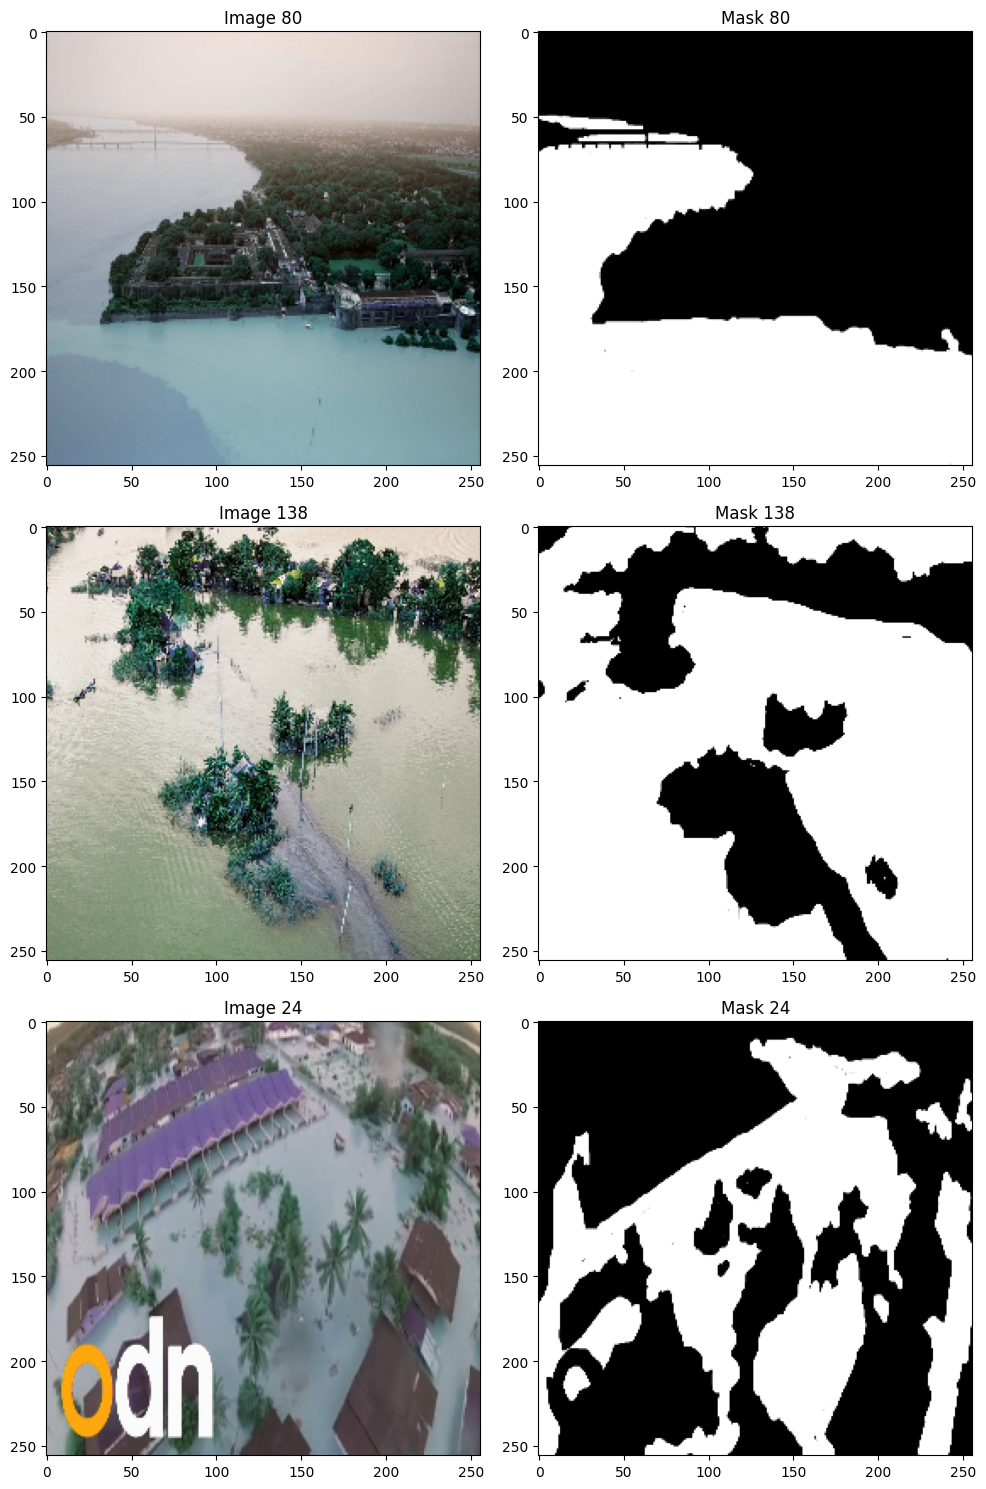

In [4]:
random_indices = np.random.choice(train_images.shape[0], 3, replace=False)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(train_images[idx])
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('on')
    
    axes[i, 1].imshow(train_masks[idx], cmap='gray')
    axes[i, 1].set_title(f"Mask {idx}")
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

### Preprocess Images and Masks for Training
To prepare the data for training, we normalize the image, and we ensure that the masks are binarized. The masks represent binary classifications (flood vs. non-flood), so any value greater than 1 is set to 1.

In [5]:
train_images = train_images / 255.0
val_images = val_images / 255.0

train_masks[train_masks > 1] = 1
val_masks[val_masks > 1] = 1

train_masks = to_categorical(train_masks, num_classes=2)
val_masks = to_categorical(val_masks, num_classes=2)

### Class Balance
Before training the model, we will check the class balance in the dataset. A highly imbalanced dataset can lead to poor model performance, particularly when one class (e.g., non-flood regions) dominates over another (flood regions).

We plot the number of pixels belonging to each class (0 or 1) in both the training and validation sets to visualize the balance between classes.

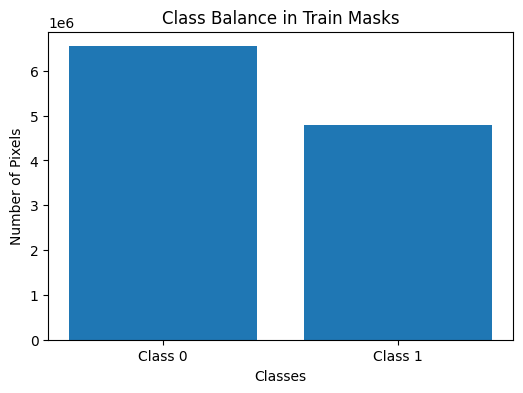

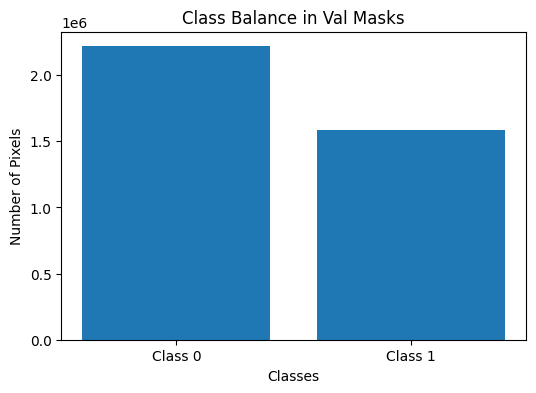

In [6]:
def plot_class_balance(masks, title):
    class_counts = np.sum(masks, axis=(0, 1, 2))
    
    plt.figure(figsize=(6, 4))
    plt.bar([0, 1], class_counts, tick_label=["Class 0", "Class 1"])
    plt.title(title)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Classes')
    plt.show()

plot_class_balance(train_masks, 'Class Balance in Train Masks')
plot_class_balance(val_masks, 'Class Balance in Val Masks')


## Model Architecture
For this project, we will be implementing a U-Net Convolutional Neural Network architecture. U-Net is highly effective for image segmentation tasks due to its encoder-decoder structure, which captures high-level features while preserving spatial information.

We will build the U-Net architecture using a pretrained ResNet50 model as the encoder to leverage the powerful feature extraction capabilities of ResNet. The decoder layers will reconstruct the segmentation mask from the encoded features.

### Building the model
In the initial version of the model, we will use 64 base filters for convolutional layers and the ReLU activation function. These values will later be fine-tuned based on model performance. Additionally, we will implement a learning rate scheduler and include dropout layers during our tuning step.

In [7]:
def unet_resnet50(input_shape):
    # Loading pre-trained ResNet50 model
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Encoder
    c1 = resnet50.get_layer('conv1_relu').output
    c2 = resnet50.get_layer('conv2_block3_out').output
    c3 = resnet50.get_layer('conv3_block4_out').output
    c4 = resnet50.get_layer('conv4_block6_out').output
    c5 = resnet50.get_layer('conv5_block3_out').output
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7, c3])
    u7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8, c2])
    u8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9, c1])
    u9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u9)
    outputs = Conv2D(2, (1, 1), activation='softmax')(u10)
    
    model = Model(inputs=resnet50.input, outputs=outputs)
    
    return model

# Compling the model
model = unet_resnet50(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2024-10-11 22:36:47.037480: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Training the Model

To improve generalization and prevent overfitting, we employ data augmentation using ImageDataGenerator. This will generate variations of the images, introducing transformations like rotations, shifts, and flips to create a more robust model.

The model will be trained for 20 epochs, and its performance will be validated using a portion of the dataset.

In [8]:
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Here we use the same seed for the image and mask so that the augmentations get applied synchronously to the image and mask pair
seed = 1
image_generator = image_datagen.flow(train_images, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(train_masks, batch_size=16, seed=seed)

def train_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield image_batch, mask_batch


train_gen = train_generator(image_generator, mask_generator)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) // 16,
                    epochs=20,
                    validation_data=(val_images, val_masks))


/home/dillonkyle/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (173, 256, 256, 2) (2 channels).
  warnings.warn(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6459 - loss: 0.7641 - val_accuracy: 0.4435 - val_loss: 1.4328
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8433 - loss: 0.3777 - val_accuracy: 0.5751 - val_loss: 13.2944
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8402 - loss: 0.3925 - val_accuracy: 0.4247 - val_loss: 46.7526
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.8717 - loss: 0.3171 - val_accuracy: 0.4210 - val_loss: 9697.2109
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8752 - loss: 0.3192 - val_accuracy: 0.4181 - val_loss: 273.8311
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8810 - loss: 0.3085 - val_accuracy: 0.4229 - val_loss: 26.8597
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.8863 - loss: 0.2892 - val_accuracy: 0.4171 - val_loss: 814.8408
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.8885 - loss: 0.2911 - val_accuracy: 0.4313 -

## Results and Analysis

Once the training is complete, we will analyze the results by plotting the training and validation accuracy and loss curves. These plots will give us insights into how well the model is learning and if any overfitting occurs.

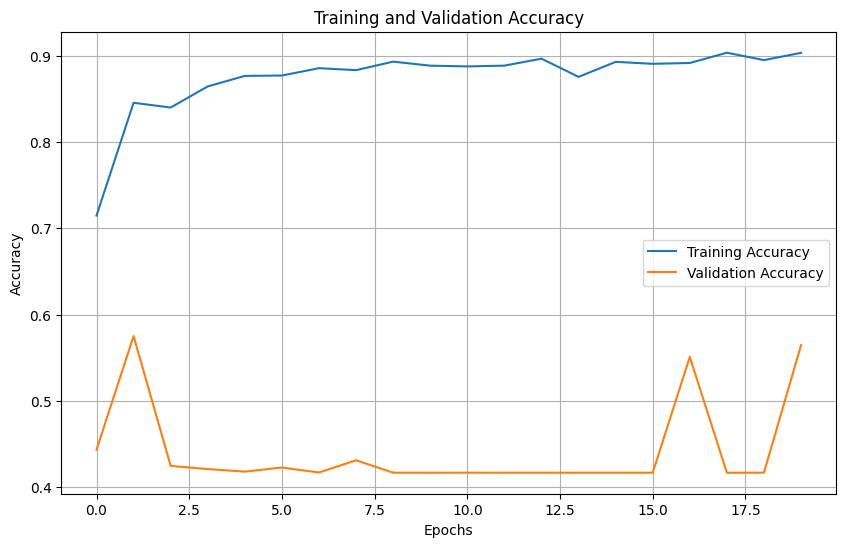

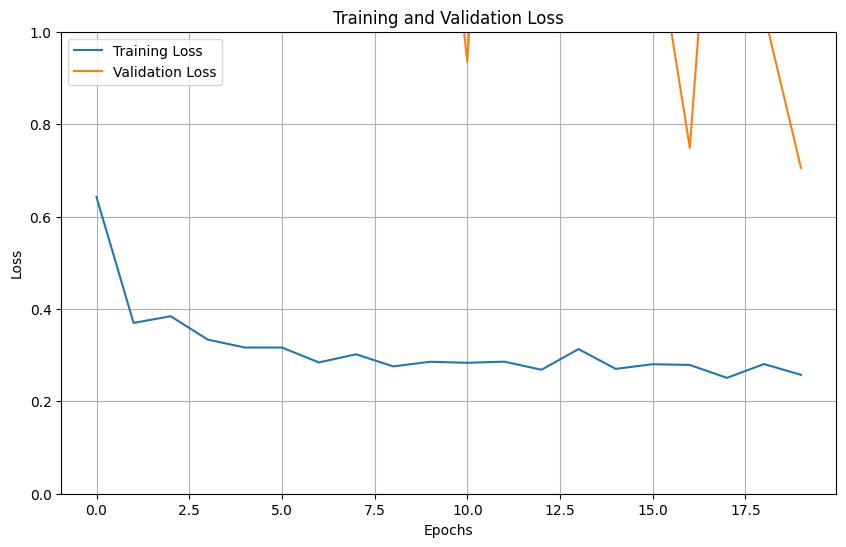

In [10]:
# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
val_loss, val_accuracy = model.evaluate(val_images, val_masks)
print(f"""
========================================================
Validation Metrics:
--------------------------------------------------------
Validation Loss: {val_loss}, 
Validation Accuracy: {val_accuracy}
""")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5616 - loss: 0.7060

Validation Metrics:
--------------------------------------------------------
Validation Loss: 0.7047768235206604, 
Validation Accuracy: 0.5645251870155334



The evaluation results show poor performance, with low accuracy scores and signs of possible overfitting, as indicated by the similarity between the training and validation metrics.

To address this issue, we will attempt to improve the model's performance through hyperparameter tuning.

### Hyperparameter Tuning
Since the initial model did not perform optimally, we will leverage Hyperband for hyperparameter tuning. Hyperband is an efficient strategy for searching through hyperparameters, focusing computational resources on promising hyperparameter combinations.

We will tune parameters such as:

- Number of filters in each layer,
- Learning rate,
- Dropout rate,
- Activation function.

In [12]:
def build_unet_model(hp):
    input_shape = (256, 256, 3)
    
    # Hyperparameters to tune
    num_filters = hp.Int('num_filters', min_value=32, max_value=128, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    activation = hp.Choice('activation', values=['relu', 'elu'])
    
    # Load pre-trained ResNet50 model
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Encoder layers
    c1 = resnet50.get_layer('conv1_relu').output
    c2 = resnet50.get_layer('conv2_block3_out').output
    c3 = resnet50.get_layer('conv3_block4_out').output
    c4 = resnet50.get_layer('conv4_block6_out').output
    c5 = resnet50.get_layer('conv5_block3_out').output
    
    # Decoder layers with hyperparameters
    u6 = Conv2DTranspose(num_filters * 8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Conv2D(num_filters * 8, (3, 3), activation=activation, padding='same')(u6)
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    
    u7 = Conv2DTranspose(num_filters * 4, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7, c3])
    u7 = Conv2D(num_filters * 4, (3, 3), activation=activation, padding='same')(u7)
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    
    u8 = Conv2DTranspose(num_filters * 2, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8, c2])
    u8 = Conv2D(num_filters * 2, (3, 3), activation=activation, padding='same')(u8)
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    
    u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9, c1])
    u9 = Conv2D(num_filters, (3, 3), activation=activation, padding='same')(u9)
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    
    u10 = Conv2DTranspose(num_filters // 2, (2, 2), strides=(2, 2), padding='same')(u9)
    outputs = Conv2D(2, (1, 1), activation='softmax')(u10)
    
    model = Model(inputs=resnet50.input, outputs=outputs)
    
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


A small subset of the dataset will be used for the tuning process

In [13]:
subset_size = 50
tune_train_images = train_images[:subset_size]
tune_train_masks = train_masks[:subset_size]

We will have our tuner attempt 10 different combinations of hyperparameters on our subset of data

In [14]:
tuner = Hyperband(
    build_unet_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperparam_tuning',
    project_name='unet_hyperband_tuning'
)

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(tune_train_images, tune_train_masks,
             epochs=3,
             validation_data=(val_images, val_masks),
             batch_size=8,
             callbacks=[early_stopping])


Reloading Tuner from hyperparam_tuning/unet_hyperband_tuning/tuner0.json
Search space summary
Default search space size: 4
num_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}


Now we can retrieve the best hyperparameters and train the model using these hyperparameters

In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
========================================================
Optimal Hyperparameters:
--------------------------------------------------------
number of filters: {best_hps.get('num_filters')}
learning rate: {best_hps.get('learning_rate')}
dropout rate: {best_hps.get('dropout_rate')}
activation function: {best_hps.get('activation')}
========================================================
""")


Optimal Hyperparameters:
--------------------------------------------------------
number of filters: 64
learning rate: 0.01
dropout rate: 0.30000000000000004
activation function: relu



In [16]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_images, train_masks,
                    epochs=50,
                    validation_data=(val_images, val_masks))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.4985 - loss: 191.1072 - val_accuracy: 0.5440 - val_loss: 1740555671156645223928430592.0000
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.4704 - loss: 17.3745 - val_accuracy: 0.4118 - val_loss: 6054206417011914951360512.0000
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.4525 - loss: 0.9665 - val_accuracy: 0.5596 - val_loss: 74207772588927614976.0000
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 51s 8s/step - accuracy: 0.5767 - loss: 1.3117 - val_accuracy: 0.5835 - val_loss: 95623177647947776.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.5889 - loss: 0.6805 - val_accuracy: 0.5796 - val_loss: 15480145313792.0000
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.5927 - loss: 0.6944 - val_accuracy: 0.5886 - val_loss: 5040362225664.0000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.5736 - loss: 0.6838 - val_accuracy: 0.5886 - val_loss: 116033740800.0000
Epoch 8

### Final Results
After hyperparameter tuning, we retrain the model using the best parameters and evaluate the model's performance on the validation dataset. We will again plot the training and validation accuracy and loss, and compare these with the initial results to see if improvements were made.

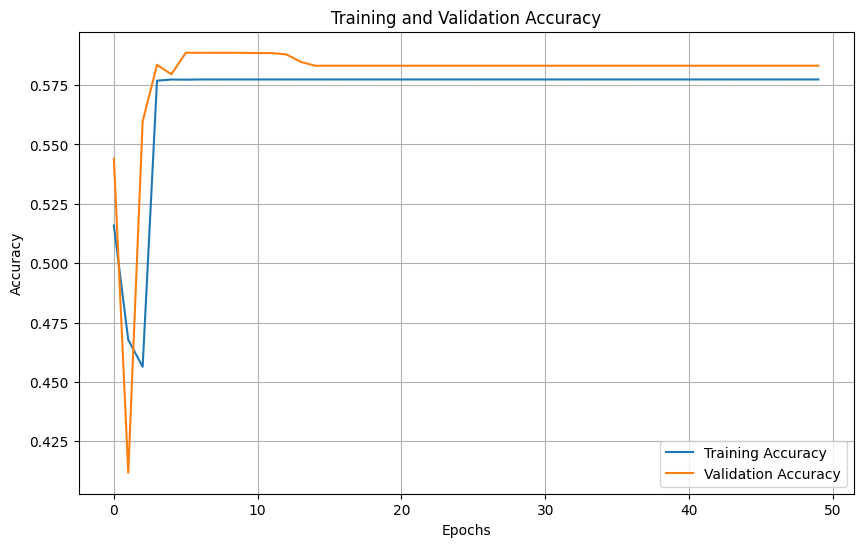

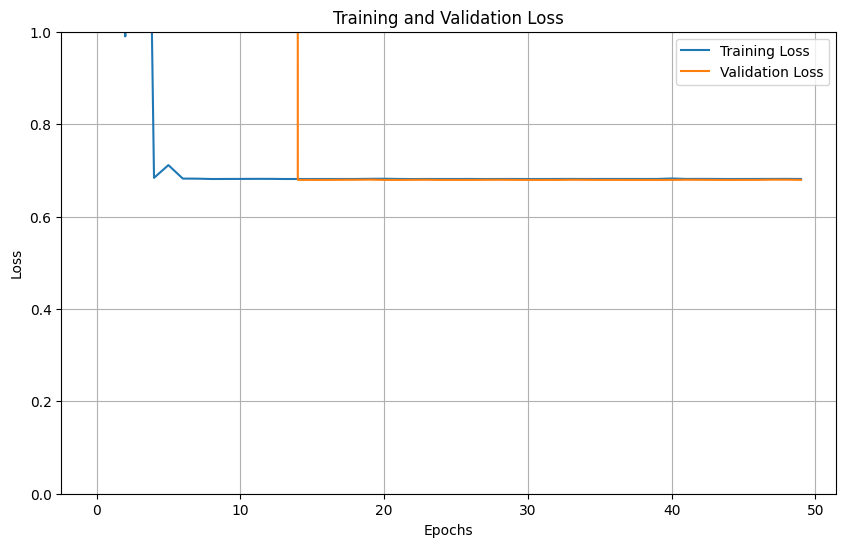

In [17]:
# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
val_loss, val_accuracy = model.evaluate(val_images, val_masks)
print(f"""
========================================================
Validation Metrics:
--------------------------------------------------------
Validation Loss: {val_loss}, 
Validation Accuracy: {val_accuracy}
""")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5788 - loss: 0.6807

Validation Metrics:
--------------------------------------------------------
Validation Loss: 0.6793723106384277, 
Validation Accuracy: 0.5831717252731323



Save the model for future use

In [24]:
model.save('flood_segmentation_model.h5')

### Use the Final Model
Now we can use our final model on our testing dataset and see the final outcome of our work

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Unique values in the thresholded mask: [0 1]


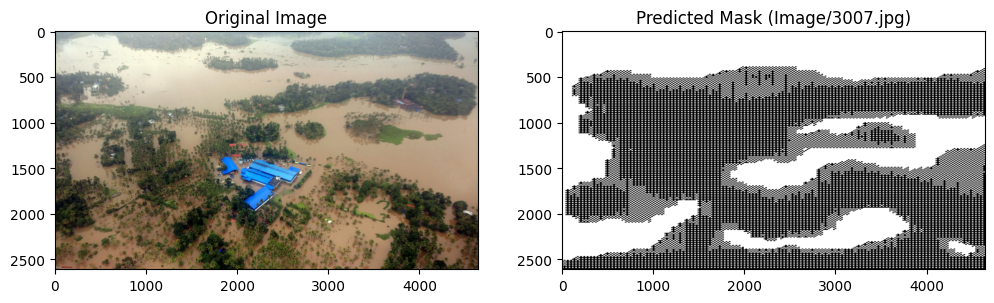

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Unique values in the thresholded mask: [0 1]


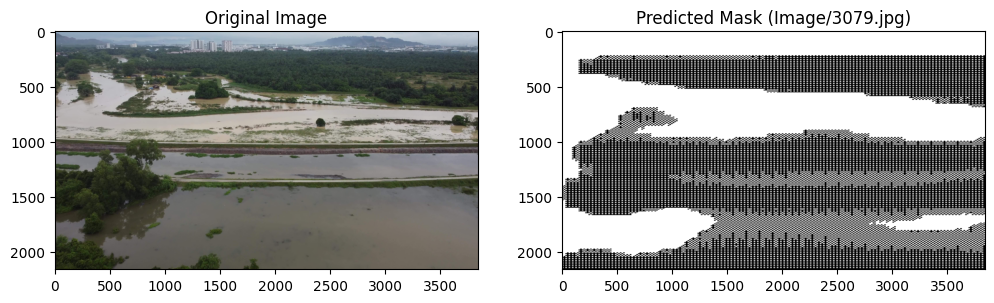

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Unique values in the thresholded mask: [0 1]


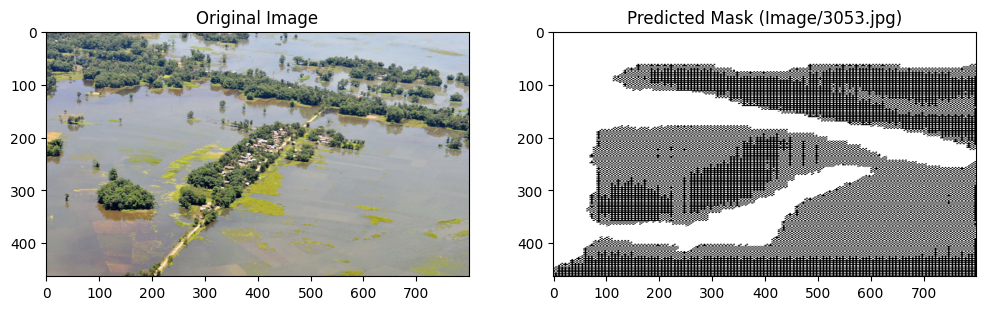

In [23]:
final_model = load_model('flood_segmentation_model.h5') 

def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    image = cv2.resize(image, target_size)
    
    image = np.expand_dims(image, axis=0)
    
    return image

def plot_prediction_mask(model, image, image_path, save_path):
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    prediction = model.predict(image)
    predicted_mask = (prediction[0] > 0.50).astype(np.uint8)

    print("Unique values in the thresholded mask:", np.unique(predicted_mask))

    predicted_mask = predicted_mask[:, :, 0]
    
    predicted_mask_resized = cv2.resize(predicted_mask.astype('float32'), 
                                        (original_image.shape[1], original_image.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)
    
    predicted_mask_resized = predicted_mask_resized * 255
    predicted_mask_resized = predicted_mask_resized.astype(np.uint8)

    cv2.imwrite(f"Predicted/{save_path}.png", predicted_mask_resized)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('on')

    ax[1].imshow(predicted_mask_resized, cmap='gray')
    ax[1].set_title(f"Predicted Mask ({image_path})")
    ax[1].axis('on')
    plt.show()

    
for idx, (i, row) in enumerate(test_df.iterrows()):
    if idx >= 3:
        break
    
    input_image_path = os.path.join('Image', row['Image'])
    image = preprocess_image(input_image_path)

    plot_prediction_mask(final_model, image, input_image_path, f"Predicted/{idx}.png")



## Conclusion
Despite resource limitations and a small dataset, the segmentation model has shown reasonable performance in identifying flood-affected areas. However, the model’s final accuracy indicates that there is significant room for improvement. Here are some possible next steps:

- Increasing the dataset size to provide the model with more varied training examples,
- Expanding the range of hyperparameters for fine-tuning,
- Using more computational resources to train deeper models with more parameters,
- Training the model for more epochs with careful regularization to avoid overfitting.

This project lays a solid foundation for further exploration and improvement, and with additional resources and data, this model could become a valuable tool for flood detection and response planning.